# Use Gensim to vectorize features2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
import numexpr as ne
import mskcc_functions as ski
import scipy.stats as scs
import feature_engineering as fe
import xgboost as xgb

from xgboost import plot_importance
from pprint import pprint
from matplotlib  import cm
from collections import Counter
from importlib import reload
from gensim import corpora, matutils, models, similarities
from nltk import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, normalize, robust_scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

sns.set_context("paper")
%matplotlib inline

Using TensorFlow backend.
/usr/lib64/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
Slow version of gensim.models.doc2vec is being used


In [2]:
class_train = pd.read_csv('./data/training_variants')
text_train = pd.read_csv("./data/training_text", sep="\|\|", engine='python',
                         header=None, skiprows=1, names=["ID","Text"])

<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<input>:2: DeprecationWarning: invalid escape sequence \|
<ipython-input-2-4467bb76c423>:2: DeprecationWarning: invalid escape sequence \|
  text_train = pd.read_csv("./data/training_text", sep="\|\|", engine='python',


In [3]:
feature_words1= pd.read_csv('./data/features_pass1_subset1.csv', header=None)
feature_words1 = list(feature_words1[0])
feature_words2 = list(set(class_train['Gene']))
feature_words = feature_words1 + feature_words2
print(len(feature_words))

926


In [4]:
my_dict = corpora.Dictionary([feature_words])

In [5]:
%%time
documents = []
tokenized_documents = []
for i in range(len(text_train)):
    doc= text_train['Text'].iloc[i]
    tokenized_doc = word_tokenize(fe.replace_with_whitespace(doc, hyphens='on'))
    
    documents.append(doc)
    tokenized_documents.append(tokenized_doc)

print(len(documents))     # double checking length
print(len(tokenized_documents))     # double checking length

3321
3321
CPU times: user 1min 52s, sys: 552 ms, total: 1min 53s
Wall time: 1min 53s


In [6]:
%time
corpus = [my_dict.doc2bow(token) for token in tokenized_documents]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [7]:
feature_matrix = matutils.corpus2dense(corpus_tfidf, num_terms=len(feature_words), num_docs=len(corpus_tfidf)).T

In [8]:
pd.DataFrame(feature_matrix).to_csv('./data/feature_matrix_pass1_subset2.csv', index=False)

<b>Try RFC</b>

In [9]:
# Import Data and extract gene and mutation type info
# Get Gene feature from 'train_variants' data
X_gene = np.array(class_train.Gene)
X_gene_int = LabelEncoder().fit_transform(X_gene.ravel()).reshape(-1, 1)
X_gene_bin = OneHotEncoder().fit_transform(X_gene_int).toarray()
gene_table = pd.DataFrame(X_gene_bin)

# Get Mutation Type from 'train_variants' data
mut_type = ski.convert_mutation_type(class_train)
X_mtype = np.array(mut_type['mutation_type'])
X_mtype_int = LabelEncoder().fit_transform(X_mtype.ravel()).reshape(-1, 1)
X_mtype_bin = OneHotEncoder().fit_transform(X_mtype_int).toarray()
mtype_table = pd.DataFrame(X_mtype_bin)

feat_mat = pd.DataFrame(feature_matrix)

In [10]:
feat_mat.shape

(3321, 926)

In [11]:
features = pd.concat([gene_table, mtype_table, feat_mat], axis=1)
print(features.shape)
X = np.array(features).astype(float)
y = np.array(class_train.Class).astype(int).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

(3321, 1207)


In [12]:
%%time
# Run RFC on the data
rfc = RandomForestClassifier(n_estimators=100, max_depth=100, n_jobs=4)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_proba = rfc.predict_proba(X_test)
print(accuracy_score(y_test, y_pred))
print(log_loss(y_test, y_proba, labels=list(range(1, 10))))

0.637274549098
1.6266356818
CPU times: user 1.41 s, sys: 14 ms, total: 1.42 s
Wall time: 670 ms


<b>XGBoost</b>

========== Iteration 1/3 ==========
[0]	train-mlogloss:2.09529	valid-mlogloss:2.11294
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[150]	train-mlogloss:0.419025	valid-mlogloss:0.99567

========== Iteration 2/3 ==========
[0]	train-mlogloss:2.09638	valid-mlogloss:2.11078
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[102]	train-mlogloss:0.423733	valid-mlogloss:0.936976

========== Iteration 3/3 ==========
[0]	train-mlogloss:2.09689	valid-mlogloss:2.1165
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[95]	train-mlogloss:0.424173	valid-mlogloss:1.04728

Average mlogloss: 0.993309
CPU times: use

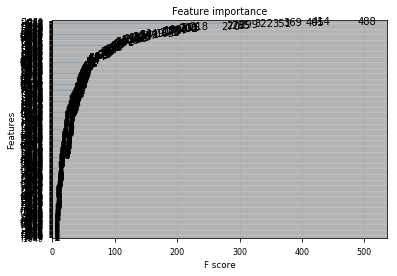

In [13]:
%%time
# Adjust the class labels so it starts with 0
y_adj = y-1

scores = []

iteration = 3
for i in range(iteration):
    print('========== Iteration %d/%d ==========' % (i+1, iteration))
    
    # Split into test and train randomly, every iteration
    x1, x2, y1, y2 = train_test_split(X, y_adj, test_size=0.15)
    
    # Set up parameters for xgboost
    params = {
            'eta': 0.1,
            'gamma': 0.8,
            'max_delta_step': 1,
            'max_depth': 12,
            'min_child_weight': 1,
            'objective': 'multi:softprob',
            'eval_metric': 'mlogloss',
            'num_class': 9,
            'seed': 1,
            'silent': True,
            'nthread' :4
            }

    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]

    model = xgb.train(params, xgb.DMatrix(x1, y1), 500,  watchlist, 
                      verbose_eval=500, early_stopping_rounds=100)

    score = log_loss(y2, model.predict(xgb.DMatrix(x2), 
                     ntree_limit=model.best_ntree_limit), 
                     labels = list(range(9)))
    scores.append(score)
    #print(score)
          
print("Average mlogloss: %f" % np.mean(scores))
plot_importance(model)

In [14]:
len(model.get_score())

395

<b>Select features based on F-score, try classification</b>

In [15]:
fscores = pd.DataFrame([val for val in model.get_score().values()])
fscores.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9])

,0
count,395.000000
mean,38.825316
std,65.777524
min,1.000000
25%,5.000000
50%,15.000000
75%,40.000000
80%,49.000000
90%,97.200000
max,488.000000


In [16]:
select_feat_ind = [int(key.replace('f', '')) for key, value in model.get_score().items() if value >=15]

selectX1 = X[:, select_feat_ind]
print('Before selection', X.shape)
print('After selection', selectX1.shape)

Before selection (3321, 1207)
After selection (3321, 203)


========== Iteration 1/3 ==========
[0]	train-mlogloss:2.09776	valid-mlogloss:2.11454
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[128]	train-mlogloss:0.422761	valid-mlogloss:0.963546

========== Iteration 2/3 ==========
[0]	train-mlogloss:2.09546	valid-mlogloss:2.11155
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[127]	train-mlogloss:0.417902	valid-mlogloss:0.935215

========== Iteration 3/3 ==========
[0]	train-mlogloss:2.096	valid-mlogloss:2.11279
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[96]	train-mlogloss:0.42996	valid-mlogloss:1.04316

Average mlogloss: 0.980642
CPU times: user

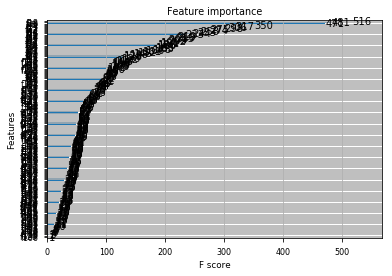

In [17]:
%%time
# Adjust the class labels so it starts with 0
y_adj = y-1

scores = []

iteration = 3
for i in range(iteration):
    print('========== Iteration %d/%d ==========' % (i+1, iteration))
    
    # Split into test and train randomly, every iteration
    x1, x2, y1, y2 = train_test_split(selectX1, y_adj, test_size=0.15)
    
    # Set up parameters for xgboost
    params = {
            'eta': 0.1,
            'gamma': 0.8,
            'max_delta_step': 1,
            'max_depth': 12,
            'min_child_weight': 1,
            'objective': 'multi:softprob',
            'eval_metric': 'mlogloss',
            'num_class': 9,
            'seed': 1,
            'silent': True,
            'nthread' :4
            }

    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]

    model2 = xgb.train(params, xgb.DMatrix(x1, y1), 500,  watchlist, 
                      verbose_eval=500, early_stopping_rounds=100)

    score = log_loss(y2, model2.predict(xgb.DMatrix(x2), 
                     ntree_limit=model2.best_ntree_limit), 
                     labels = list(range(9)))
    scores.append(score)
          
print("Average mlogloss: %f" % np.mean(scores))
plot_importance(model2)

Repeat another round of cutting features in half

In [18]:
fscores2 = pd.DataFrame([val for val in model2.get_score().values()])
fscores2.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.9])

,0
count,197.000000
mean,78.258883
std,86.371108
min,1.000000
25%,27.000000
50%,48.000000
75%,97.000000
80%,109.000000
90%,191.000000
max,516.000000


In [19]:
select_feat_ind2 = [int(key.replace('f', '')) for key, value in model.get_score().items() if value >=48]

selectX2 = X[:, select_feat_ind2]
print('Before selection', X.shape)
print('After selection', selectX2.shape)

Before selection (3321, 1207)
After selection (3321, 80)


========== Iteration 1/3 ==========
[0]	train-mlogloss:2.09767	valid-mlogloss:2.11266
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[102]	train-mlogloss:0.431815	valid-mlogloss:1.00417

========== Iteration 2/3 ==========
[0]	train-mlogloss:2.09592	valid-mlogloss:2.11337
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[109]	train-mlogloss:0.433678	valid-mlogloss:1.08704

========== Iteration 3/3 ==========
[0]	train-mlogloss:2.09673	valid-mlogloss:2.10937
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[115]	train-mlogloss:0.447023	valid-mlogloss:0.954501

Average mlogloss: 1.015239
CPU times: u

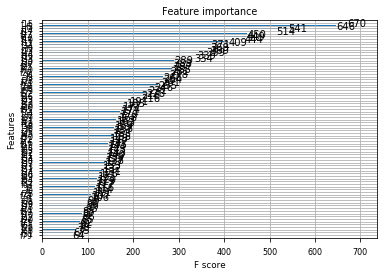

In [20]:
%%time
# Adjust the class labels so it starts with 0
y_adj = y-1

scores = []

iteration = 3
for i in range(iteration):
    print('========== Iteration %d/%d ==========' % (i+1, iteration))
    
    # Split into test and train randomly, every iteration
    x1, x2, y1, y2 = train_test_split(selectX2, y_adj, test_size=0.15)
    
    # Set up parameters for xgboost
    params = {
            'eta': 0.1,
            'gamma': 0.8,
            'max_delta_step': 1,
            'max_depth': 12,
            'min_child_weight': 1,
            'objective': 'multi:softprob',
            'eval_metric': 'mlogloss',
            'num_class': 9,
            'seed': 1,
            'silent': True,
            'nthread' :4
            }

    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]

    model2 = xgb.train(params, xgb.DMatrix(x1, y1), 500,  watchlist, 
                      verbose_eval=500, early_stopping_rounds=100)

    score = log_loss(y2, model2.predict(xgb.DMatrix(x2), 
                     ntree_limit=model2.best_ntree_limit), 
                     labels = list(range(9)))
    scores.append(score)
          
print("Average mlogloss: %f" % np.mean(scores))
plot_importance(model2)

Alternatively, get the best 20% from the first model

In [21]:
select_feat_ind3 = [int(key.replace('f', '')) for key, value in model.get_score().items() if value >=49]

selectX3 = X[:, select_feat_ind3]
print('Before selection', X.shape)
print('After selection', selectX3.shape)

Before selection (3321, 1207)
After selection (3321, 80)


========== Iteration 1/3 ==========
[0]	train-mlogloss:2.0963	valid-mlogloss:2.11299
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[102]	train-mlogloss:0.436798	valid-mlogloss:0.997437

========== Iteration 2/3 ==========
[0]	train-mlogloss:2.09666	valid-mlogloss:2.10933
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[88]	train-mlogloss:0.447913	valid-mlogloss:0.998893

========== Iteration 3/3 ==========
[0]	train-mlogloss:2.09416	valid-mlogloss:2.11502
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
Stopping. Best iteration:
[259]	train-mlogloss:0.435399	valid-mlogloss:1.03398

Average mlogloss: 1.010103
CPU times: us

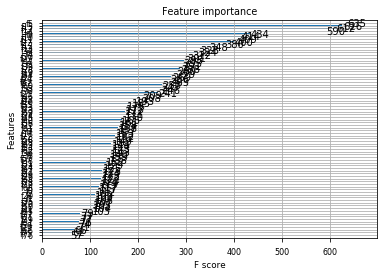

In [22]:
%%time
# Adjust the class labels so it starts with 0
y_adj = y-1

scores = []

iteration = 3
for i in range(iteration):
    print('========== Iteration %d/%d ==========' % (i+1, iteration))
    
    # Split into test and train randomly, every iteration
    x1, x2, y1, y2 = train_test_split(selectX3, y_adj, test_size=0.15)
    
    # Set up parameters for xgboost
    params = {
            'eta': 0.1,
            'gamma': 0.8,
            'max_delta_step': 1,
            'max_depth': 12,
            'min_child_weight': 1,
            'objective': 'multi:softprob',
            'eval_metric': 'mlogloss',
            'num_class': 9,
            'seed': 1,
            'silent': True,
            'nthread' :4
            }

    watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]

    model2 = xgb.train(params, xgb.DMatrix(x1, y1), 500,  watchlist, 
                      verbose_eval=500, early_stopping_rounds=100)

    score = log_loss(y2, model2.predict(xgb.DMatrix(x2), 
                     ntree_limit=model2.best_ntree_limit), 
                     labels = list(range(9)))
    scores.append(score)
          
print("Average mlogloss: %f" % np.mean(scores))
plot_importance(model2)

<b>PCA to visualize vector space</b>

Whole X

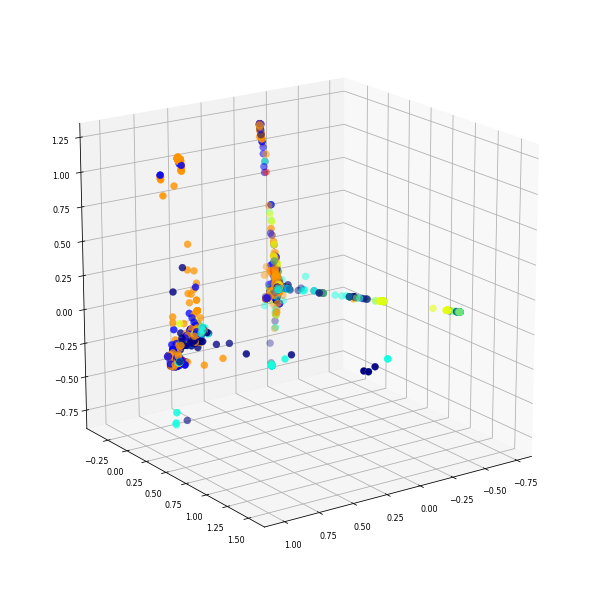

In [23]:
# Create a new table with ID as index
pca_table = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(X)
pca_table['x'] = pca.fit_transform(X).T[0]
pca_table['y'] = pca.fit_transform(X).T[1]
pca_table['z'] = pca.fit_transform(X).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_table.x, pca_table.y, pca_table.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

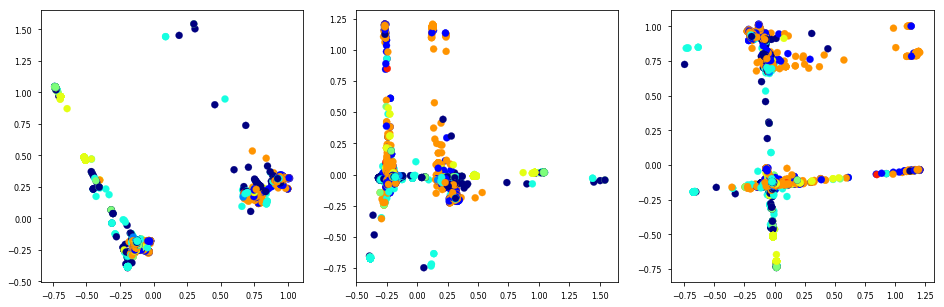

In [24]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_table.x, pca_table.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_table.y, pca_table.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_table.z, pca_table.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

selectX1

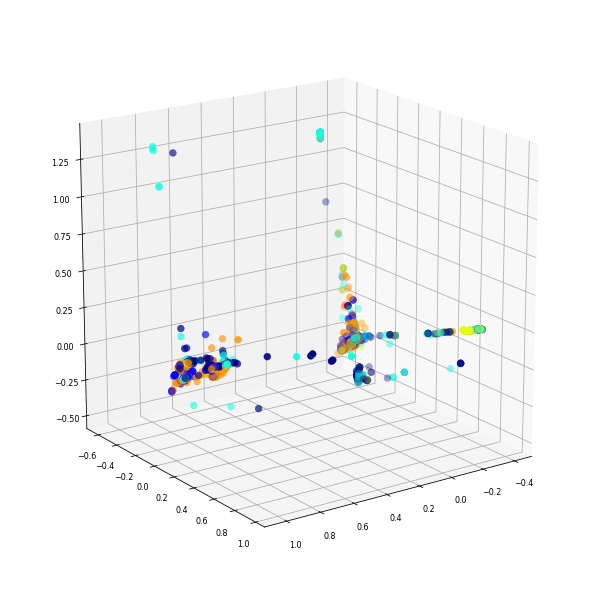

In [25]:
# Create a new table with ID as index
pca_table1 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(selectX1)
pca_table1['x'] = pca.fit_transform(selectX1).T[0]
pca_table1['y'] = pca.fit_transform(selectX1).T[1]
pca_table1['z'] = pca.fit_transform(selectX1).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_table1.x, pca_table1.y, pca_table1.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

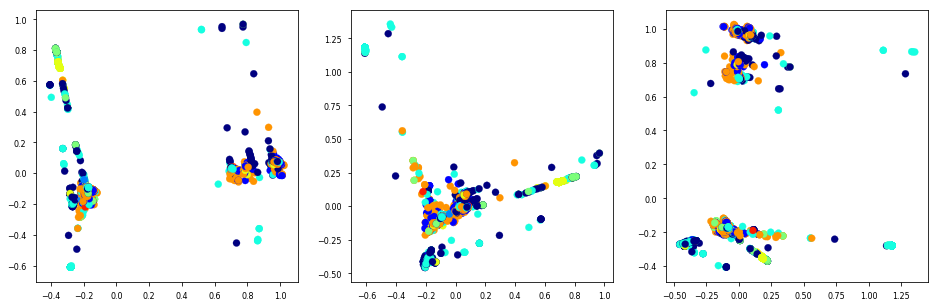

In [26]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_table1.x, pca_table1.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_table1.y, pca_table1.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_table1.z, pca_table1.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

selectX2

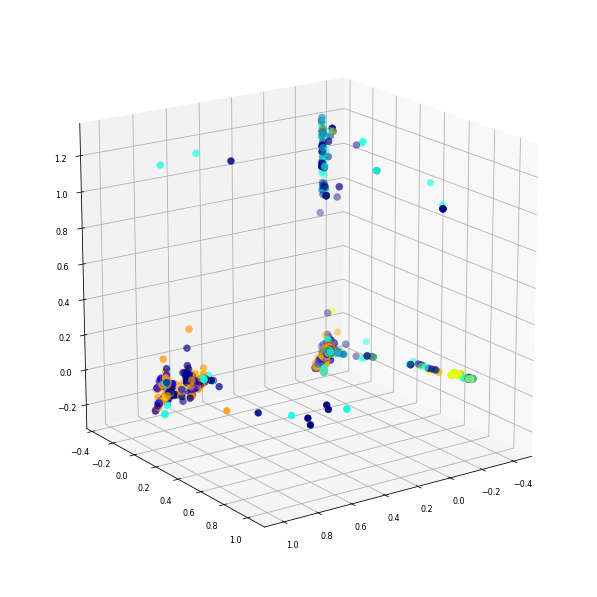

In [27]:
# Create a new table with ID as index
pca_table2 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(selectX2)
pca_table2['x'] = pca.fit_transform(selectX2).T[0]
pca_table2['y'] = pca.fit_transform(selectX2).T[1]
pca_table2['z'] = pca.fit_transform(selectX2).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_table2.x, pca_table2.y, pca_table2.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

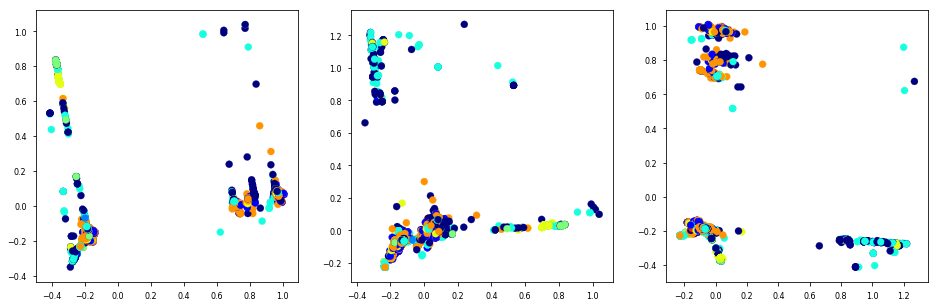

In [28]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_table2.x, pca_table2.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_table2.y, pca_table2.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_table2.z, pca_table2.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')

selectX3

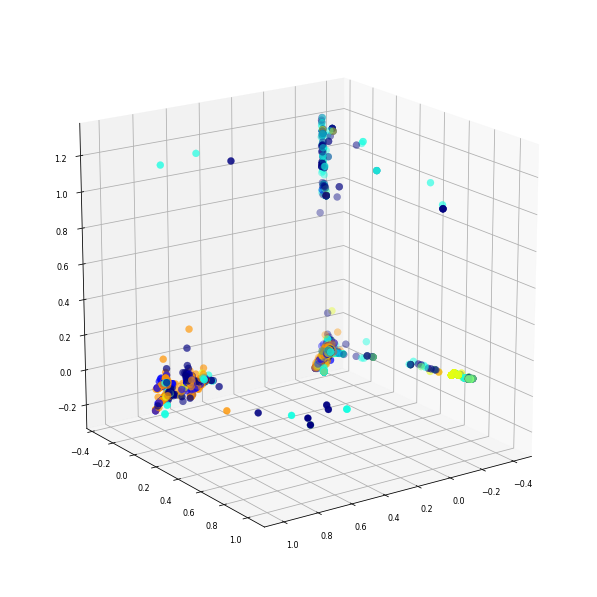

In [29]:
# Create a new table with ID as index
pca_table3 = pd.DataFrame(index=class_train.ID)
pca = PCA(n_components=3)
pca.fit(selectX3)
pca_table3['x'] = pca.fit_transform(selectX3).T[0]
pca_table3['y'] = pca.fit_transform(selectX3).T[1]
pca_table3['z'] = pca.fit_transform(selectX3).T[2]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, elev=18, azim=55)#, rect=[0, 0, .95, 1])
ax.scatter(pca_table3.x, pca_table3.y, pca_table3.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet)

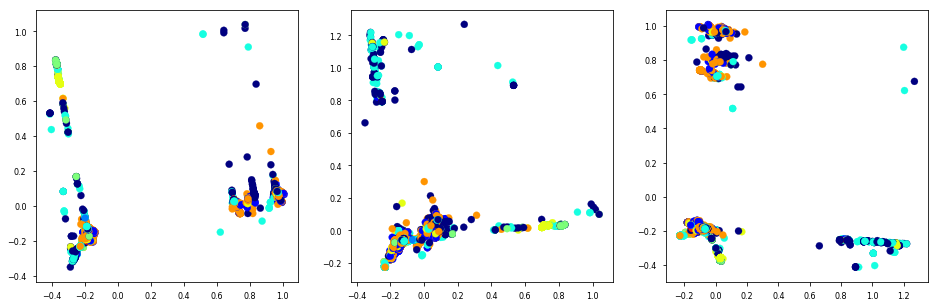

In [30]:
fig, (ax1, ax2, ax3 ) = plt.subplots(1,3, figsize=(16,5))
ax1.scatter(pca_table3.x, pca_table3.y, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA1-PCA2')
ax2.scatter(pca_table3.y, pca_table3.z, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA2-PCA3')
ax3.scatter(pca_table3.z, pca_table3.x, c=class_train['Class'], marker = 'o', s=50, cmap = cm.jet, label='PCA3-PCA1')